<a href="https://colab.research.google.com/github/purnimabepala/Python-/blob/main/Heart_dieases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

raw shape: (303, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Class distribution:
 target
0    0.541254
1    0.458746
Name: proportion, dtype: float64

Cross-v

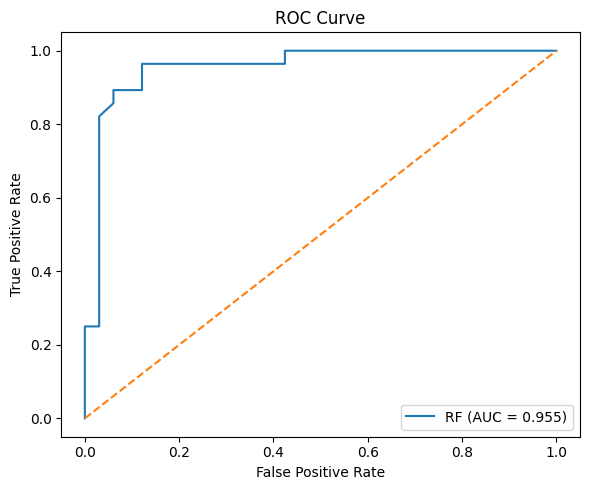


Saved pipeline to heart_disease_rf_pipeline.joblib


In [1]:
# heart_disease_pipeline.py
# Requirements:
# pip install pandas numpy scikit-learn matplotlib joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import joblib

# 1) Load dataset (UCI processed Cleveland file)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# column names from UCI attribute info (14 columns)
cols = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak", "slope",
    "ca", "thal", "target"
]

df = pd.read_csv(url, header=None, names=cols, na_values='?')
print("raw shape:", df.shape)
print(df.head())

# 2) Inspect missing values
print("\nMissing values per column:\n", df.isna().sum())

# Several rows use '?' for ca and thal — we'll impute numeric columns with median
num_cols = df.columns.drop('target')
imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

# 3) Make target binary: 0 -> no disease, 1..4 -> disease present (1)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Quick class balance
print("\nClass distribution:\n", df['target'].value_counts(normalize=True))

# 4) Feature matrix X and labels y
X = df.drop("target", axis=1)
y = df['target']

# 5) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) Scale numeric features (tree models don't strictly need it, but it's useful if switching models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 7) Baseline model: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# 8) Cross-validation (stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nCross-validated ROC AUC (train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 9) Fit on full training set and evaluate on test set
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

print("\nTest set metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 10) Feature importances
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:\n", feat_importances)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_score(y_test,y_proba):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 11) Save model + scaler for later use
joblib.dump({"model": rf, "scaler": scaler}, "heart_disease_rf_pipeline.joblib")
print("\nSaved pipeline to heart_disease_rf_pipeline.joblib")